# MNIST Classification
It's been a long time MNIST, how have you been? Say hello to all the digits for me.

In [0]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [4]:
# Downloading training dataset
dataset = MNIST(root='data/', download=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [5]:
len(dataset)

60000

In [0]:
train_dataset = MNIST(root='data/', train=False)

In [7]:
len(train_dataset)

10000

In [8]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FB9B3786048>, 5)

In [9]:
dataset[0][0]

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

Label =  5


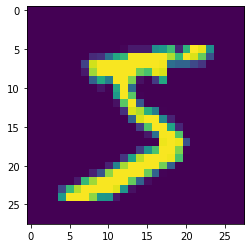

In [11]:
image, label = dataset[0]
plt.imshow(image) # cmap='gray'
print('Label = ', label)

Pytorch cant work directly with images, hence we need to transform them into tensors using pytorch.transforms

In [12]:
import torchvision.transforms as transforms
# loading dataset again
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


This is of form (color depth, height, width)

## Torch version of Train-Test Split

In [13]:
from torch.utils.data import random_split
# for train test split at 1/6th
train_ds, val_ds = random_split(dataset=dataset, lengths=[int(len(dataset)*5/6), int(len(dataset)*1/6)])
len(train_ds), len(val_ds)

(50000, 10000)

## DataLoader

In [0]:
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False)

In [15]:
image, label = train_ds[10]; label

5

## Model

In [16]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# LogReg
model = nn.Linear(input_size, num_classes)
model.weight.shape, model.weight

(torch.Size([10, 784]), Parameter containing:
 tensor([[ 0.0063,  0.0054,  0.0193,  ..., -0.0042, -0.0339,  0.0349],
         [-0.0033,  0.0059,  0.0129,  ...,  0.0262, -0.0279, -0.0306],
         [-0.0202, -0.0112,  0.0241,  ...,  0.0072, -0.0090, -0.0121],
         ...,
         [-0.0113, -0.0086,  0.0315,  ..., -0.0202, -0.0088, -0.0260],
         [-0.0177, -0.0148, -0.0329,  ...,  0.0338, -0.0264, -0.0050],
         [ 0.0201,  0.0109,  0.0067,  ..., -0.0296, -0.0072,  0.0006]],
        requires_grad=True))

In [17]:
model.bias.shape

torch.Size([10])

The input should be flattened (bear with me here)
Hence instead of going forward with this model, make custom model that inherits from torch.nn.Module class

In [18]:
# Inheritance
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__() # Call constructor of nn.Module 
        self.linear = nn.Linear(input_size, num_classes) # method overriding
    
    def forward(self, xb):
        xb = xb.reshape(-1, 784) # reshaping 28*28 to 784
        out = self.linear(xb)
        return out
# Now when calling the forward(data_batch), first it is reshaped to a tensor of size 784
# Then, nn.Linear is called


model = MnistModel()
# Now the model has a linear attribute
model.linear.weight.shape, model.linear.bias.shape

(torch.Size([10, 784]), torch.Size([10]))

In [19]:
model.parameters(), list(model.parameters())

(<generator object Module.parameters at 0x7fb9b2d65ca8>, [Parameter containing:
  tensor([[ 0.0067,  0.0137,  0.0058,  ...,  0.0301, -0.0339,  0.0048],
          [-0.0095,  0.0016, -0.0355,  ...,  0.0300, -0.0106,  0.0261],
          [ 0.0128, -0.0355, -0.0177,  ..., -0.0337,  0.0083,  0.0045],
          ...,
          [-0.0264,  0.0335,  0.0003,  ...,  0.0185,  0.0073,  0.0039],
          [ 0.0162,  0.0292, -0.0113,  ..., -0.0301, -0.0022,  0.0201],
          [ 0.0353, -0.0342, -0.0139,  ...,  0.0063, -0.0122, -0.0177]],
         requires_grad=True), Parameter containing:
  tensor([-0.0227, -0.0072, -0.0130,  0.0195, -0.0041,  0.0097, -0.0003, -0.0038,
          -0.0032, -0.0067], requires_grad=True)])

## Direct prediction (without training)

In [20]:
for images, labels in train_loader:
    outputs = model(images)
    break # stops at first 128 sized batch
print(outputs.shape) # we get 128 outputs of 10 sized tensors

torch.Size([128, 10])


In [21]:
outputs[0]

tensor([ 0.2920, -0.0593, -0.0073,  0.1750, -0.0682,  0.3251,  0.2801,  0.0100,
         0.1076,  0.0760], grad_fn=<SelectBackward>)

In [22]:
outputs[0].sum()

tensor(1.1310, grad_fn=<SumBackward0>)

So, these are raw predictions, not probabilities. Use softmax. It is included in torch.nn.functional

In [23]:
import torch.nn.functional as F

# Apply softmax along each output row
probs = F.softmax(outputs, dim=1) # as outputs.shape == [128,10] and we need to calculate softmax along dim output.shape[1] ie 10
probs[0].sum(), probs[0].sum().item()

(tensor(1.0000, grad_fn=<SumBackward0>), 0.9999999403953552)

In [24]:
probs.shape

torch.Size([128, 10])

In [25]:
# Find the max of the probs to get prediction
max_probs, preds = torch.max(probs, dim=1)
max_probs, preds

(tensor([0.1224, 0.1182, 0.1410, 0.1313, 0.1230, 0.1239, 0.1205, 0.1289, 0.1251,
         0.1242, 0.1309, 0.1326, 0.1573, 0.1313, 0.1354, 0.1549, 0.1581, 0.1381,
         0.1307, 0.1485, 0.1169, 0.1602, 0.1307, 0.1319, 0.1243, 0.1368, 0.1321,
         0.1353, 0.1263, 0.1344, 0.1602, 0.1504, 0.1269, 0.1143, 0.1149, 0.1336,
         0.1258, 0.1286, 0.1323, 0.1258, 0.1342, 0.1205, 0.1201, 0.1164, 0.1513,
         0.1285, 0.1264, 0.1210, 0.1380, 0.1323, 0.1298, 0.1226, 0.1416, 0.1394,
         0.1354, 0.1279, 0.1152, 0.1169, 0.1219, 0.1300, 0.1491, 0.1538, 0.1364,
         0.1508, 0.1087, 0.1401, 0.1453, 0.1233, 0.1497, 0.1112, 0.1337, 0.1328,
         0.1154, 0.1392, 0.1156, 0.1249, 0.1221, 0.1206, 0.1247, 0.1405, 0.1331,
         0.1386, 0.1301, 0.1127, 0.1268, 0.1282, 0.1226, 0.1170, 0.1330, 0.1218,
         0.1188, 0.1195, 0.1107, 0.1116, 0.1173, 0.1434, 0.1224, 0.1230, 0.1264,
         0.1193, 0.1206, 0.1400, 0.1325, 0.1262, 0.1448, 0.1322, 0.1276, 0.1508,
         0.1292, 0.1354, 0.1

In [26]:
labels

tensor([3, 8, 3, 7, 2, 7, 8, 3, 8, 5, 9, 8, 8, 6, 8, 4, 0, 6, 3, 0, 5, 5, 5, 3,
        5, 9, 6, 4, 5, 2, 0, 4, 5, 6, 1, 5, 8, 3, 6, 0, 0, 4, 1, 7, 2, 2, 8, 3,
        4, 3, 4, 6, 7, 0, 9, 5, 7, 7, 9, 3, 9, 2, 6, 3, 1, 8, 4, 0, 3, 5, 4, 9,
        8, 9, 3, 7, 9, 7, 2, 8, 4, 5, 9, 1, 7, 5, 7, 2, 2, 2, 1, 8, 0, 3, 7, 0,
        2, 8, 6, 2, 9, 5, 3, 6, 3, 0, 8, 5, 1, 8, 7, 1, 6, 6, 3, 0, 1, 8, 7, 2,
        1, 3, 2, 1, 4, 1, 0, 5])

## Evaluation Metrics and Loss function 

In [29]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

accuracy(outputs, labels)

tensor(0.1406)

In [31]:
loss_fn = F.cross_entropy

# loss for the current batch of data
loss = loss_fn(outputs, labels); loss

tensor(2.3025, grad_fn=<NllLossBackward>)

## Model Training

In [0]:
# Make model class again
class MnistModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes, bias=True)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images) # model(input)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc} # dict

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print('Epoch {}, val_loss = {:.4f}, val_acc = {:.4f}'.format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()

In [0]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(model, train_loader, val_loader, epochs, lr, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # training
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # validation
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [45]:
result0 = evaluate(model, val_loader)
result0

{'val_acc': 0.14309731125831604, 'val_loss': 2.2986984252929688}

In [46]:
history1 = fit(model, train_loader, val_loader, 10, 0.001)

Epoch 0, val_loss = 1.9335, val_acc = 0.6055
Epoch 1, val_loss = 1.6697, val_acc = 0.7182
Epoch 2, val_loss = 1.4729, val_acc = 0.7599
Epoch 3, val_loss = 1.3243, val_acc = 0.7799
Epoch 4, val_loss = 1.2099, val_acc = 0.7930
Epoch 5, val_loss = 1.1199, val_acc = 0.8027
Epoch 6, val_loss = 1.0476, val_acc = 0.8094
Epoch 7, val_loss = 0.9884, val_acc = 0.8146
Epoch 8, val_loss = 0.9391, val_acc = 0.8197
Epoch 9, val_loss = 0.8973, val_acc = 0.8246


In [47]:
history2 = fit(model, train_loader, val_loader, 20, 0.001)

Epoch 0, val_loss = 0.8616, val_acc = 0.8282
Epoch 1, val_loss = 0.8306, val_acc = 0.8318
Epoch 2, val_loss = 0.8034, val_acc = 0.8340
Epoch 3, val_loss = 0.7794, val_acc = 0.8368
Epoch 4, val_loss = 0.7580, val_acc = 0.8398
Epoch 5, val_loss = 0.7388, val_acc = 0.8419
Epoch 6, val_loss = 0.7215, val_acc = 0.8433
Epoch 7, val_loss = 0.7057, val_acc = 0.8457
Epoch 8, val_loss = 0.6914, val_acc = 0.8471
Epoch 9, val_loss = 0.6782, val_acc = 0.8489
Epoch 10, val_loss = 0.6662, val_acc = 0.8506
Epoch 11, val_loss = 0.6550, val_acc = 0.8521
Epoch 12, val_loss = 0.6446, val_acc = 0.8534
Epoch 13, val_loss = 0.6350, val_acc = 0.8554
Epoch 14, val_loss = 0.6259, val_acc = 0.8559
Epoch 15, val_loss = 0.6175, val_acc = 0.8568
Epoch 16, val_loss = 0.6096, val_acc = 0.8579
Epoch 17, val_loss = 0.6022, val_acc = 0.8589
Epoch 18, val_loss = 0.5952, val_acc = 0.8596
Epoch 19, val_loss = 0.5886, val_acc = 0.8606


## Plottong training history

Text(0.5, 1.0, 'training history')

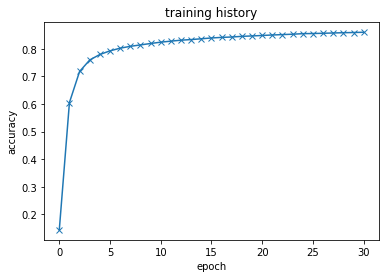

In [48]:
history = [result0] + history1 + history2
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('training history')

## Testing

In [0]:
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())

7


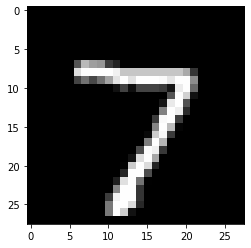

In [52]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print(label)

In [57]:
img.unsqueeze(0).shape, img.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1, 28, 28]))

label:  7


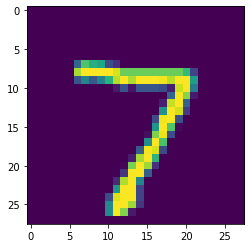

In [60]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

img, label = test_dataset[0]
plt.imshow(img[0])
print('label: ',label)

In [61]:
predict_image(img, model)

7

Yaay

## Overall accuracy against test set

In [62]:
test_loader = DataLoader(test_dataset, batch_size=128)
result = evaluate(model, test_loader)
result

{'val_acc': 0.871835470199585, 'val_loss': 0.5532974600791931}

## Save the model

In [0]:
torch.save(model.state_dict(), 'mnist-logistics.pth')

The .state_dict method returns an OrderedDict containing all the weights and bias matrices mapped to the right attributes of the model.

In [64]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0269,  0.0117,  0.0159,  ...,  0.0148,  0.0212,  0.0021],
                      [-0.0317, -0.0217, -0.0310,  ..., -0.0251,  0.0304,  0.0107],
                      [-0.0250,  0.0207, -0.0332,  ..., -0.0006,  0.0179, -0.0003],
                      ...,
                      [-0.0269,  0.0124, -0.0229,  ...,  0.0126, -0.0073,  0.0286],
                      [-0.0120,  0.0134, -0.0356,  ...,  0.0294, -0.0040, -0.0180],
                      [-0.0130,  0.0145, -0.0006,  ..., -0.0211,  0.0198, -0.0222]])),
             ('linear.bias',
              tensor([-0.0428,  0.0836, -0.0032, -0.0169,  0.0114,  0.0441, -0.0306,  0.0429,
                      -0.1570, -0.0271]))])

## Loading the Model
To load the model weights, instantiate a new object of the class MnistModel, and use the .load_state_dict method.



In [65]:
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist-logistics.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0269,  0.0117,  0.0159,  ...,  0.0148,  0.0212,  0.0021],
                      [-0.0317, -0.0217, -0.0310,  ..., -0.0251,  0.0304,  0.0107],
                      [-0.0250,  0.0207, -0.0332,  ..., -0.0006,  0.0179, -0.0003],
                      ...,
                      [-0.0269,  0.0124, -0.0229,  ...,  0.0126, -0.0073,  0.0286],
                      [-0.0120,  0.0134, -0.0356,  ...,  0.0294, -0.0040, -0.0180],
                      [-0.0130,  0.0145, -0.0006,  ..., -0.0211,  0.0198, -0.0222]])),
             ('linear.bias',
              tensor([-0.0428,  0.0836, -0.0032, -0.0169,  0.0114,  0.0441, -0.0306,  0.0429,
                      -0.1570, -0.0271]))])

Okay, cool